In [3]:
import keras
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import model.u_net as unet
from model.augmentations import randomHueSaturationValue
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import data
import numpy as np
import cv2

image_dir = "../data/Segmentation/images/"
labels_dir = "../data/Segmentation/labels/"

input_size = 256
SIZE = (256, 256)
batch_size = 16
epochs = 10

ids_train = data.load_image_and_mask_ids()
ids_train_split, ids_valid_split = train_test_split(ids_train, test_size=0.2, random_state=42)

print('Training on {} samples'.format(len(ids_train_split)))
print('Validating on {} samples'.format(len(ids_valid_split)))

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Training on 113 samples
Validating on 29 samples


In [4]:
#from board_extractor_v2 import extract_board
#import model.u_net as unet


SIZE = (256, 256)

img = cv2.imread("../data/Segmentation/images/02d6100b-61d2-4e50-8edd-6b04ed2ed056.JPG")
cmp = cv2.resize(img, (256, 256))

#board, _ = extract_board(cmp, img)

model = unet.get_unet_coords()
model.load_weights('../weights/best_weights_coord.hdf5')

#image_batch = np.array([cmp], np.float32) / 255

#predicted_coords_batch = model.predict(image_batch)
#predicted_coords = predicted_coords_batch[0].reshape((4,2))

#mask = fix_mask(predicted_mask)
#print(predicted_coords)

In [6]:
#get batch

for x_b, y_b in valid_generator():

    pred = model.predict(x_b)
    break
    

In [ ]:
label = np.array([0.06640625, 0.08984375, 0.9453125,  0.06640625, 0.94140625, 0.93359375, 0.09375,    0.93359375])
label = label.reshape((4, 2))
label = np.array([label])
print(label)

mat = np.array([[ 1.05381929e+00,  6.35689210e-02, -2.60256882e+01],
 [-6.35689230e-02,  1.05381927e+00, -1.37520447e+01],
 [ 1.03429738e-10, -1.16709043e-10,  1.00000000e+00]])

label = cv2.perspectiveTransform(label, mat)

print(label)

label = label.reshape((8,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


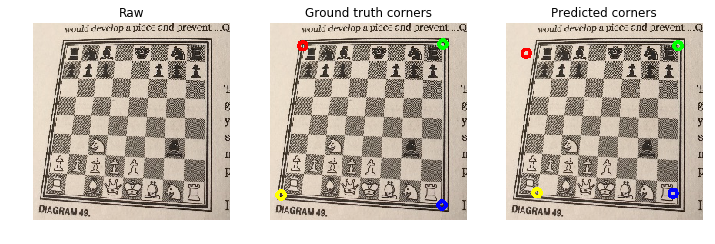

In [14]:
#print(x_b.shape)
#print(y_b.shape)
#print(pred.shape)

i = 11
imgs = draw_labels_and_predictions(x_b[i], y_b[i], pred[i])

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.imshow(imgs[0])
plt.title("Raw")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(imgs[1])
plt.title("Ground truth corners")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(imgs[2])
plt.title("Predicted corners")
plt.axis("off")


plt.show()

In [8]:
#

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255,0)]

def draw_labels_and_predictions(img, labels, pred):
    """img is a 256, 256, 3 image, labels and pred are (8, ) coordinates"""
    
    img1 = img
    img2 = img.copy()
    img3 = img.copy()
    
    j = 0
    for p in labels.reshape((4, 2)):
        p *= 255
        cv2.circle(img2, (p[0], p[1]), 5, colors[j], thickness=3)
        j += 1
    
    j = 0
    for p in pred.reshape((4, 2)):
        p *= 255
        cv2.circle(img3, (p[0], p[1]), 5, colors[j], thickness=3)
        j += 1
    
    return [img1, img2, img3]


In [2]:
def train_generator():
    while True:
        for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            for id in ids_train_batch:
                img = cv2.imread('{}{}.JPG'.format(image_dir, id))
                #img = cv2.resize(img, (input_size, input_size))
                #mask = cv2.imread('{}{}.JPG'.format(mask_dir, id), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (input_size, input_size))
                label = np.load(labels_dir + id + ".npy")
                #print("{}: {}".format(id,label.shape))

                img = randomHueSaturationValue(img,
                                               hue_shift_limit=(-50, 50),
                                               sat_shift_limit=(-5, 5),
                                               val_shift_limit=(-15, 15))
                img, label = randomShiftScaleRotateCorners(img, label,
                                                   shift_limit=(-0.0625, 0.0625),
                                                   scale_limit=(-0.1, 0.1),
                                                   rotate_limit=(-5, 5))
                #img, mask = randomHorizontalFlip(img, mask)
                #mask = np.expand_dims(mask, axis=2)
                x_batch.append(img)
                y_batch.append(label)
                
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch)
            #y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch


def valid_generator():
    while True:
        for start in range(0, len(ids_valid_split), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids_valid_split))
            ids_valid_batch = ids_valid_split[start:end]
            for id in ids_valid_batch:
                img = cv2.imread('{}{}.JPG'.format(image_dir, id))
                #img = cv2.resize(img, (input_size, input_size))
                #mask = cv2.imread('{}{}.JPG'.format(mask_dir, id), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (input_size, input_size))
                #mask = np.expand_dims(mask, axis=2)
                label = np.load(labels_dir + id + ".npy")
                x_batch.append(img)
                y_batch.append(label)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch)
            #y_batch = np.array(y_batch, np.float32) / 255
            yield x_batch, y_batch

In [1]:
def randomShiftScaleRotateCorners(image, label,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-5, 5), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        #mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
        #                           borderValue=(
        #                               0, 0,
        #                               0,))

        label = np.array(label.reshape((4, 2)), dtype=np.float32)
        label = np.array([label])
        label = cv2.perspectiveTransform(label, mat)
        label = label.reshape((8,))

    return image, label

NameError: name 'cv2' is not defined